<a href="https://colab.research.google.com/github/nibrunie/cosmosim/blob/master/solar_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import argparse
import math

In [20]:
dt = 10000.0#0.01
CST_G = 6.67408e-11 # m^3.kg^-1.s^-2

# number of simulated steps
NUM_STEPS = 100

SUN_MASS = 1.989e30 # kg
MOON_MASS = 7.34767309e22 # kg
ASTRO_UNIT = 1.49597e11 # m

VENUS_MASS = 4.87e24 # kg
VENUS_RADIUS = 1.08e11 # meters
VENUS_ORBITAL_PERIOD = 224.7 # days

EARTH_MASS = 5.972e24 # kg

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/marsfact.html
MARS_MASS = 6.39e23
MARS_RADIUS = 2.2792e11 # semi-major axis
MARS_YEAR = 687.973 # days, tropical orbit period

JUPITER_MASS = SUN_MASS # 1.898e27
JUPITER_ORBITAL_RADIUS = 7.786e11
JUPITER_ORBITAL_PERIOD = 4331

SATURN_MASS = 5.68e26
SATURN_ORBITAL_RADIUS = 1.4335e12
SATURN_ORBITAL_PERIOD = 10747

classes to define cosmological objects

In [21]:

class Cosmos:
    def __init__(self, display_scale=np.array([1.0, 1.0]), gravitionnal_cst=CST_G):
        self.body_list = []
        # scale to be applied before display to reduce simulated
        # coords to window coords
        self.display_scale = display_scale
        # local cosmos gravitionnal constant
        self.gravitionnal_cst = gravitionnal_cst

    # automatically adapats the display scale factor to the furthest object
    def adaptDisplayScale(self):
        origin = Point((0, 0))
        maxRadius = max(Point.distance_to(origin, body) for body in self.body_list)
        print(f"maxRadius={maxRadius:e}")
        displayScale = 0.90 / maxRadius
        displayScaleVector = np.array([displayScale, displayScale], dtype="float64")
        self.display_scale = displayScaleVector

    def add_body(self, new_body):
        self.body_list.append(new_body)

    def add_bodies(self, bodies):
        for body in bodies:
            self.add_body(body)

    def compute_forces(self, attracted):
        acc_force = np.zeros(2)
        for attractor in self.body_list:
            if attractor is attracted: continue
            acc_force += self.attractionTo(attractor, attracted)
        return acc_force

    def attractionTo(self, attractor, attracted):
        value = self.gravitionnal_cst * attracted.mass * attractor.mass / attractor.distance_to(attracted)**2
        unit_vector = attracted.unit_vector_fromto(attractor)
        return value * unit_vector

    def compile_matrices(self):
        # self.body_list update will not be taken into account between two
        # calls to compile_matrices
        self.NUM_BODIES = len(self.body_list)
        self.pos_matrix = np.stack([body.pos for body in self.body_list]).astype("float64")
        self.speed_matrix = np.stack([body.current_speed for body in self.body_list]).astype("float64")
        self.mass_matrix = np.array([body.mass for body in self.body_list], dtype="float64")
        self.shape_2d = (self.NUM_BODIES, self.NUM_BODIES)
        self.mass_matrix = self.mass_matrix.reshape((self.NUM_BODIES, 1))
        self.mass_product_matrix = self.mass_matrix @ np.transpose(self.mass_matrix)
        self.reduce_matrix = np.array([1.0] * self.NUM_BODIES, dtype="float64").reshape((self.NUM_BODIES, 1))
        self.inv_mass_matrix = np.float64(1.0) / self.mass_matrix

        self.weighted_g_matrix = (self.mass_product_matrix * self.gravitionnal_cst).astype("float64")
        # value valid for float64, uses to generate an identity matrix with infinity
        # as coefficient without multiplying 0 by infinity
        NEAR_INFINITY = np.float64(2**600)
        # diagnoal matrix with infinity as unique value (used to
        # set to 0 the diagnoal of 1.0 / distance_matrix)
        self.infinity_diag = NEAR_INFINITY * (NEAR_INFINITY * np.identity(self.NUM_BODIES))

    def update_pos_matrix(self, dt):
        horyzontal_x = np.broadcast_to(self.pos_matrix[...,0], self.shape_2d)
        horyzontal_y = np.broadcast_to(self.pos_matrix[...,1], self.shape_2d)
        vertical_x = np.transpose(horyzontal_x)
        vertical_y = np.transpose(horyzontal_y)
        diff_x = horyzontal_x - vertical_x
        diff_y = horyzontal_y - vertical_y
        square_distance_matrix = diff_x * diff_x + diff_y * diff_y
        distance_matrix = np.sqrt(square_distance_matrix)
        #square_distance_matrix = square_distance_matrix + self.infinity_diag
        distance_matrix = distance_matrix + self.infinity_diag
        inv_distance_matrix = np.float64(1.0) / (distance_matrix)

        gravitational_force = inv_distance_matrix * inv_distance_matrix * self.weighted_g_matrix
        unit_vector_x = diff_x * inv_distance_matrix
        unit_vector_y = diff_y * inv_distance_matrix
        acc_x = (unit_vector_x * gravitational_force) @ self.reduce_matrix
        acc_y = (unit_vector_y * gravitational_force) @ self.reduce_matrix

        acc_x *= self.inv_mass_matrix
        acc_y *= self.inv_mass_matrix
        # speed matrix can be updated with dt and (acc_x, acc_y)
        acc_matrix = np.transpose(np.stack([acc_x, acc_y])).reshape((self.NUM_BODIES, 2))
        self.speed_matrix += dt * acc_matrix
        self.pos_matrix += dt * self.speed_matrix
        return self.pos_matrix

    def compute_acceleration(self, body):
        acceleration = self.compute_forces(body) / body.mass
        return acceleration

    def matrix_evolution(self, dt, time, nb_steps=1):
        # simulate nb_steps before updating visual trajectory
        for step_id in range(nb_steps):
            pos_matrix = self.update_pos_matrix(dt)
        for index, body in enumerate(self.body_list):
            body.pos = pos_matrix[index]
        return map(lambda b: b.update_trajectory(time, self.display_scale), self.body_list)

    def evolution(self, dt, time):
        acc_map = {}
        # NOTES: all the acceleration must be computed before any position is updated
        for body in self.body_list:
            acc_map[body] = self.compute_acceleration(body)
        for body in self.body_list:
            # speed update
            body.update_speed(dt, acc_map[body])
            # position update
            body.update_pos(dt)
        return map(lambda b: b.update_trajectory(time, self.display_scale), self.body_list)

    def animation(self, fig, nb_unit_steps=1):
        # matplotlib animation
        def init():
            """ plot initialization """
            return [b.plot for b in self.body_list]

        def animate(i):
            """ plot i-th step """
            #return universe.evolution(dt, i)
            print(f"anim {i}")
            return list(self.matrix_evolution(dt, i, nb_steps=nb_unit_steps))

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=NUM_STEPS,
                                      blit=False, repeat=True)

        return anim


class Trajectory:
    """ visualized trajectory """
    def __init__(self, nb_points, index=0):
        self.points = np.zeros((2, nb_points))
        self.index = index

    def add_point(self, pt):
        self.points[0][self.index] = pt[0]
        self.points[1][self.index] = pt[1]
        self.index += 1

    @property
    def x(self):
        return self.points[0]
    @property
    def y(self):
        return self.points[1]

class Point:
    def __init__(self, pos):
        # current 2D position
        self.pos = pos

    def distance_to(pt0, pt1):
        """ compute distance between Point pt0 and Point pt1 """
        return np.linalg.norm(pt0.pos - pt1.pos)
    def unit_vector_fromto(pt0, pt1):
        """ build a unit 2D vector from Point pt0 to Point pt1 """
        return (pt1.pos - pt0.pos) / pt0.distance_to(pt1)


class Body(Point):
    """ Astronomical body """
    def __init__(self, init_pos, init_speed, nb_points=NUM_STEPS, mass=1, plot_args={}):
        Point.__init__(self, init_pos)
        self.current_speed = init_speed
        self.trajectory = Trajectory(nb_points)
        self.plot, = plt.plot([], [], **plot_args)
        self.mass = mass

    def update_pos(self, dt):
        self.pos += dt * self.current_speed
    def update_speed(self, dt, acc):
        self.current_speed += dt * acc
    def update_trajectory(self, time, display_scale):
        scaled_point = self.pos * display_scale
        self.trajectory.add_point(scaled_point)
        x = self.trajectory.x[time-10:time]
        y = self.trajectory.y[time-10:time]
        self.plot.set_data(x, y)
        return self.plot



class Planet(Body):
    """ Solar system planet """
    def __init__(self, name, mass, radius, orbital_period_days=365.242, start_angle=0.0, start_tilt=0.0, speed_factor=1.0, plot_args=None):
        init_pos = np.array([radius * math.cos(start_angle), radius * math.sin(start_angle)], dtype="float64")
        speed_value = speed_factor * np.float64(2 * math.pi * radius / (orbital_period_days * 24.0 * 60.0 * 60.0))
        init_speed = speed_value * np.array([math.cos(math.pi/2.0 + start_angle + start_tilt), math.sin(math.pi/2.0 + start_angle + start_tilt)], dtype="float64")
        Body.__init__(self, init_pos, init_speed, mass=mass, plot_args=plot_args)
        self.name = name

def simulate_solar_system():
    # Simulating solar system using data from
    # https://nssdc.gsfc.nasa.gov/planetary/factsheet/
    xmin, xmax = -1, 2
    ymin, ymax = -1, 1

    fig = plt.figure() # initialise la figure
    line, = plt.plot([],[])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    SUN_MASS = 1.989e30 # kg
    MOON_MASS = 7.34767309e22 # kg
    ASTRO_UNIT = 1.49597e11 # m

In [22]:
def simulate_solar_system():
    # Simulating solar system using data from
    # https://nssdc.gsfc.nasa.gov/planetary/factsheet/
    xmin, xmax = -1, 2
    ymin, ymax = -1, 1

    fig = plt.figure() # initialise la figure
    line, = plt.plot([],[])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    DISPLAY_SCALE = 0.5 / ASTRO_UNIT
    DISPLAY_SCALE_VECTOR = np.array([DISPLAY_SCALE, DISPLAY_SCALE], dtype="float64")

    sun = Body(np.array([0., 0.], dtype="float64"), np.array([0., 0.], dtype="float64"), mass=SUN_MASS, plot_args={"linewidth": 10, "color":"orange", "marker":"o"})
    
    venus = Planet("venus", VENUS_MASS, VENUS_RADIUS, orbital_period_days=VENUS_ORBITAL_PERIOD, start_angle=math.pi/2.0, plot_args={"linewidth":3, "color":"grey"})


    earth = Planet("earth", EARTH_MASS, ASTRO_UNIT, orbital_period_days=365.242, start_angle=math.pi, plot_args={"linewidth":3, "color":"blue"})

    mars = Planet("mars", MARS_MASS, MARS_RADIUS, orbital_period_days=MARS_YEAR, start_angle=0.0, plot_args={"linewidth":3, "color":"red"})

    jupiter = Planet("jupiter", JUPITER_MASS, JUPITER_ORBITAL_RADIUS, orbital_period_days=JUPITER_ORBITAL_PERIOD, start_angle=0.0, plot_args={"linewidth":4, "color":"green"})

    saturn = Planet("saturn", SATURN_MASS, SATURN_ORBITAL_RADIUS, orbital_period_days=SATURN_ORBITAL_PERIOD, start_angle=0.0, plot_args={"linewidth":4, "color":"purple"})


    solar_system = Cosmos(display_scale=DISPLAY_SCALE_VECTOR)
    solar_system.add_bodies([sun, venus, earth, mars, jupiter, saturn])

    # adding asteroids
    for i in range(200):
        asteroid_mass = 1e24 + random.random() * 5e9
        asteroid_orbital_radius = 6e11 + random.random() * 3e11
        asteroid = Planet("asteroid_%d" % i,
                          asteroid_mass,
                          asteroid_orbital_radius,
                          orbital_period_days=(2000),
                          speed_factor=(0.75 + random.random() * 0.5),
                          start_angle=(math.pi * 2.0 * random.random()),
                          start_tilt=(random.random() * math.pi / 8 - math.pi / 16),
                          plot_args={"linewidth": 1, "color": "black"})
        solar_system.add_body(asteroid)

    solar_system.adaptDisplayScale()
    solar_system.compile_matrices()

    return solar_system.animation(fig, nb_unit_steps=10)

maxRadius=1.433500e+12
anim 0
anim 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply


anim 2
anim 3
anim 4
anim 5
anim 6
anim 7
anim 8
anim 9
anim 10
anim 11
anim 12
anim 13
anim 14
anim 15
anim 16
anim 17
anim 18
anim 19
anim 20
anim 21
anim 22
anim 23
anim 24
anim 25
anim 26
anim 27
anim 28
anim 29
anim 30
anim 31
anim 32
anim 33
anim 34
anim 35
anim 36
anim 37
anim 38
anim 39
anim 40
anim 41
anim 42
anim 43
anim 44
anim 45
anim 46
anim 47
anim 48
anim 49
anim 50
anim 51
anim 52
anim 53
anim 54
anim 55
anim 56
anim 57
anim 58
anim 59
anim 60
anim 61
anim 62
anim 63
anim 64
anim 65
anim 66
anim 67
anim 68
anim 69
anim 70
anim 71
anim 72
anim 73
anim 74
anim 75
anim 76
anim 77
anim 78
anim 79
anim 80
anim 81
anim 82
anim 83
anim 84
anim 85
anim 86
anim 87
anim 88
anim 89
anim 90
anim 91
anim 92
anim 93
anim 94
anim 95
anim 96
anim 97
anim 98
anim 99


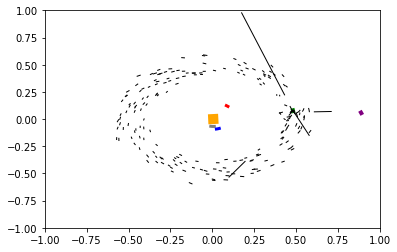

In [23]:
from matplotlib import rc
rc('animation', html='jshtml')
anim = simulate_solar_system()
anim